In [55]:
# Load packages
from __future__ import division
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import mean_squared_error

from sklearn.feature_selection import SelectKBest, chi2, f_classif, RFECV
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression, ElasticNet, ElasticNetCV, RidgeCV, Ridge, LassoCV, Lasso

from sklearn.model_selection import cross_val_score

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Considering there are a lot of features in the dataset, make 
# the display wider to make sure every column could be shown.
pd.set_option('display.max_columns', 500)

# Load the data
house = pd.read_csv('./housing.csv')

# Estimatie house value.

Estimate the sale price of properties based on their "fixed" characteristics, such as neighborhood, lot size, number of stories.

##  Data cleaning

In [2]:
# First glance at data.
house.head(2)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0         NaN   
1             1          TA             6        Typ           1          TA   

  GarageType  GarageYrBlt GarageFinish  GarageCars  GarageArea GarageQual  \
0     Attchd       2003.0          RFn           2         548         TA   
1     Attchd       1976.0          RFn           2         460         TA   

  GarageCond PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  \
0         TA          Y           0           61              0          0   
1         TA          Y         298            0              0          0   

   ScreenPorch  PoolArea PoolQC Fence MiscFeature  MiscVal  MoSold  YrSold  \
0            0         0    NaN   NaN         NaN        0       2    2008   
1            0         0    NaN   NaN         NaN        0       5    2007   

  SaleType SaleCondition  SalePrice  
0       WD        Normal     208500  
1       WD        Normal     181500

In [3]:
# shape of house dataset
house.shape

(1460, 81)

In [4]:
# house.dtype

In [5]:
# Check basic data infomation
# house.info()

In [6]:
# Describe numeric data
# house.describe().T

### Drop unwanted rows
Any non residential houses are out of this analysis, so they should be dropped.

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM	Residential Medium Density

In [7]:
# Remove any houses that are not residential from the dataset.
print house.MSZoning.unique(), house.shape
house = house[house.MSZoning != 'C (all)']
print house.MSZoning.unique(), house.shape

# All commercial house, which categories as 'C (all)', now has been dropped (10 rows).

['RL' 'RM' 'C (all)' 'FV' 'RH'] (1460, 81)
['RL' 'RM' 'FV' 'RH'] (1450, 81)


### Drop unwanted features
Majority in Alley, FireplaceQu, PoolQC, Fence and MiscFeature feature are missing. Therefore, either fillna or imputation are not going to do any good to future model. So, these 5 columns should be dropped.

In [8]:
# Check if any null data
for i in range(len(house.columns)):
    # This loop will go through each column to check if there are more than 
    # 20% data missing. And then, print out selected columns.
    nullValue = house.iloc[:,i].isnull().sum()
    nullprop = float(nullValue) / 14.50
    if nullValue != 0 and nullprop > 20:
        print '{} Column has {} null value, which is {}% missing data'.format(
            house.columns[i], nullValue, nullprop)
        
# Drop Alley, FireplaceQu, PoolQC, Fence, MiscFeature, 
# since most of data in those columns are missing.
print house.shape
house.drop(['Id', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], 
           axis=1, inplace=True)
print house.shape

# There are 6 columns dropped. Id column also be dropped 
# since it does no help for predicting.

Alley Column has 1361 null value, which is 93.8620689655% missing data
FireplaceQu Column has 681 null value, which is 46.9655172414% missing data
PoolQC Column has 1443 null value, which is 99.5172413793% missing data
Fence Column has 1172 null value, which is 80.8275862069% missing data
MiscFeature Column has 1398 null value, which is 96.4137931034% missing data
(1450, 81)
(1450, 75)


### Fill NA

In [9]:
# Find columns who still have null value
mc = house.columns[pd.isnull(house).sum() > 0]
for c in mc[1:]:
    print 'There are {} missing value in {}.'.format(house[c].isnull().sum(), c)
    if house[c].dtype == 'object':
        house[c] = house[c].fillna('None')
    else:
        house[c] = house[c].fillna(house[c].mean())

print '\nAfter fill na, there are still {} missing data in {} colums.'.format(
    house.isnull().sum().sum(), mc[0])

# All columns with dtype float64 will be filled mean value in nan blank
# All columns with dtype object will be filled with 'None'

There are 8 missing value in MasVnrType.
There are 8 missing value in MasVnrArea.
There are 37 missing value in BsmtQual.
There are 37 missing value in BsmtCond.
There are 38 missing value in BsmtExposure.
There are 37 missing value in BsmtFinType1.
There are 38 missing value in BsmtFinType2.
There are 1 missing value in Electrical.
There are 79 missing value in GarageType.
There are 79 missing value in GarageYrBlt.
There are 79 missing value in GarageFinish.
There are 79 missing value in GarageQual.
There are 79 missing value in GarageCond.

After fill na, there are still 259 missing data in LotFrontage colums.


There are very little missing data in above columns, therefore, I decide to fill in those missing spot with means or 'None' for object columns. 

### Imputing Missing Data: Lotfrontage
17.9%

Since 259/1450 missing data in LotFrontage columns, which is a very larger precentage, I am going to impute missing values with a predictive model so that I can keep those valuable data.

In [10]:
house.LotFrontage.isnull().sum()

259

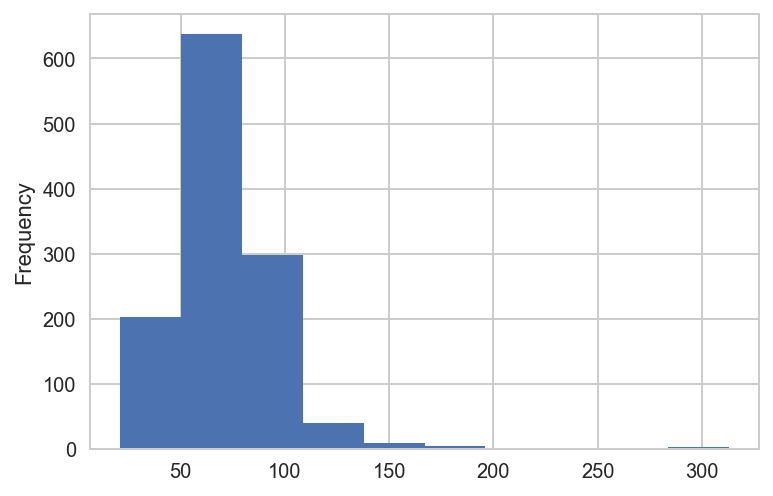

In [11]:
house.LotFrontage.plot(kind='hist')

In [12]:
house.LotFrontage = house.LotFrontage.fillna(house.LotFrontage.mean())

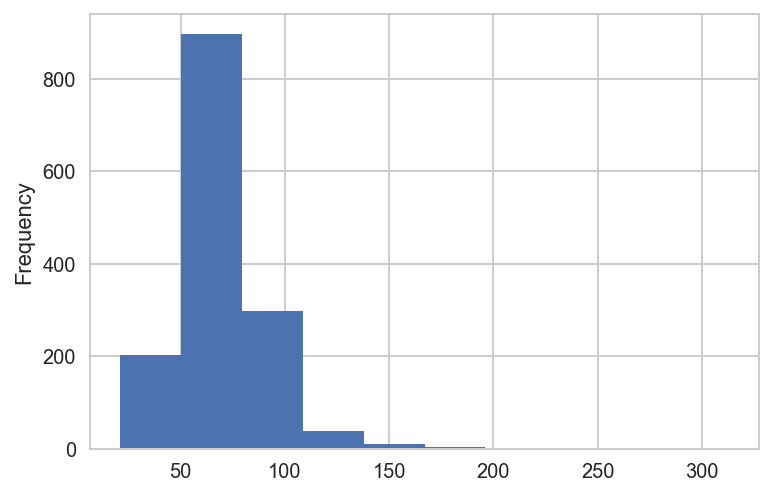

In [13]:
house.LotFrontage.plot(kind='hist')

In [14]:
house.isnull().sum().sum()

0L

## Identify Fixed Feature

Fixed feature:
- MSSubClass: Identifies the type of dwelling involved in the sale.	
- LotFrontage: Linear feet of street connected to property
- LandContour: Flatness of the property
- LotConfig: Lot configuration
- LandSlope: Slope of property
- Neighborhood: Physical locations within Ames city limits
- Condition1: Proximity to various conditions
- Condition2: Proximity to various conditions (if more than one is present)
- BldgType: Type of dwelling
- YearBuilt: Original construction date
- YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)
- PoolArea: Pool area in square feet
- 1stFlrSF: First Floor square feet
- 2ndFlrSF: Second floor square feet
- GrLivArea: Above grade (ground) living area square feet ?
- BsmtFullBath: Basement full bathrooms
- BsmtHalfBath: Basement half bathrooms
- FullBath: Full bathrooms above grade
- HalfBath: Half baths above grade
- Bedroom: Bedrooms above grade (does NOT include basement bedrooms)
- Kitchen: Kitchens above grade
- TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
- Fireplaces: Number of fireplaces
- GarageCars: Size of garage in car capacity
- GarageArea: Size of garage in square feet
- OpenPorchSF: Open porch area in square feet
- EnclosedPorch: Enclosed porch area in square feet
- 3SsnPorch: Three season porch area in square feet
- ScreenPorch: Screen porch area in square feet
- PoolArea: Pool area in square feet

In [15]:
fixed_feature = ['MSSubClass', 'LotFrontage', 'LotArea', 'LandContour', 'LotConfig',
                 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
                 'BldgType', 'YearBuilt', 'YearRemodAdd', 'PoolArea', 
                 '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 
                 'BsmtHalfBath', 'FullBath', 'HalfBath', 'Bedroom', 
                 'Kitchen', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 
                 'GarageArea', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
                 'ScreenPorch''PoolArea', 'GarageYrBlt', 'TotalBsmtSF', 
                 'BedroomAbvGr', 'KitchenAbvGr', 'MoSold', 'YrSold', 'SalePrice']

In [16]:
fixed_house = house[[x for x in house.columns if x in fixed_feature]].copy()
fixed_house.shape

(1450, 34)

In [17]:
fixed_house.head(2)

MSSubClass  LotFrontage  LotArea LandContour LotConfig LandSlope  \
0          60         65.0     8450         Lvl    Inside       Gtl   
1          20         80.0     9600         Lvl       FR2       Gtl   

  Neighborhood Condition1 Condition2 BldgType  YearBuilt  YearRemodAdd  \
0      CollgCr       Norm       Norm     1Fam       2003          2003   
1      Veenker      Feedr       Norm     1Fam       1976          1976   

   TotalBsmtSF  1stFlrSF  2ndFlrSF  GrLivArea  BsmtFullBath  BsmtHalfBath  \
0          856       856       854       1710             1             0   
1         1262      1262         0       1262             0             1   

   FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  Fireplaces  \
0         2         1             3             1             8           0   
1         2         0             3             1             6           1   

   GarageYrBlt  GarageCars  GarageArea  OpenPorchSF  EnclosedPorch  3SsnPorch  \
0       2003.0           2         548           61              0          0   
1       1976.0           2         460            0              0          0   

   PoolArea  MoSold  YrSold  SalePrice  
0         0       2    2008     208500  
1         0       5    2007     181500

## Explotary Data Analysis

### Corelationship between sale price and time-related features

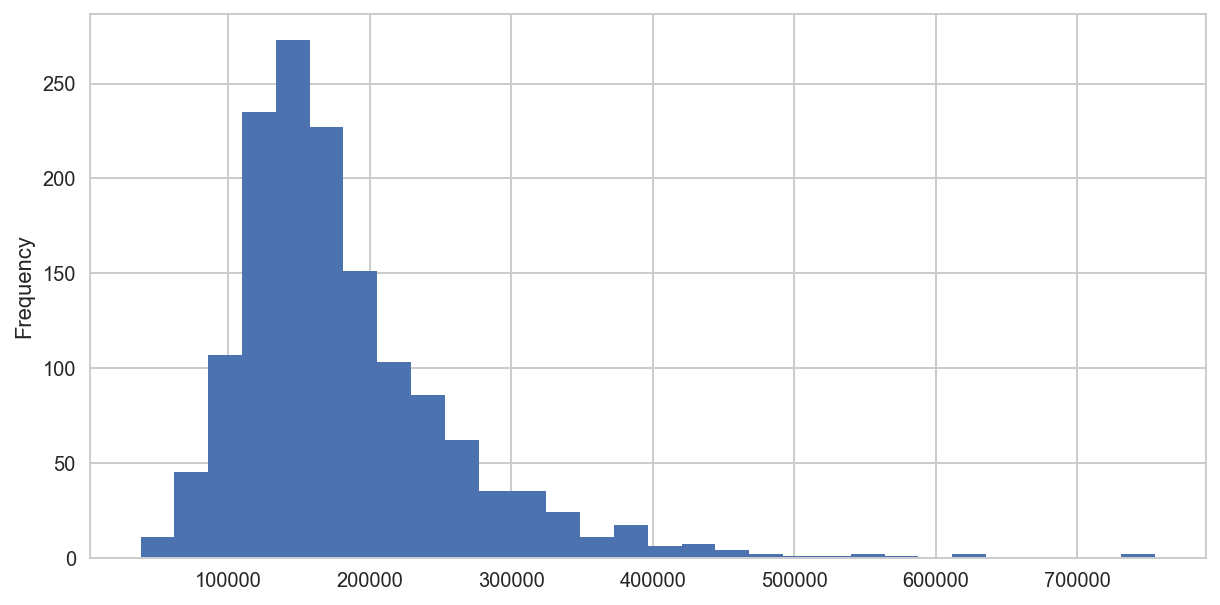

In [18]:
house['SalePrice'].plot(kind='hist', figsize=(10,5), bins=30)

According to histogram above, sale price basically normally distributed. Obviously, there are some outliers which should be removed later.

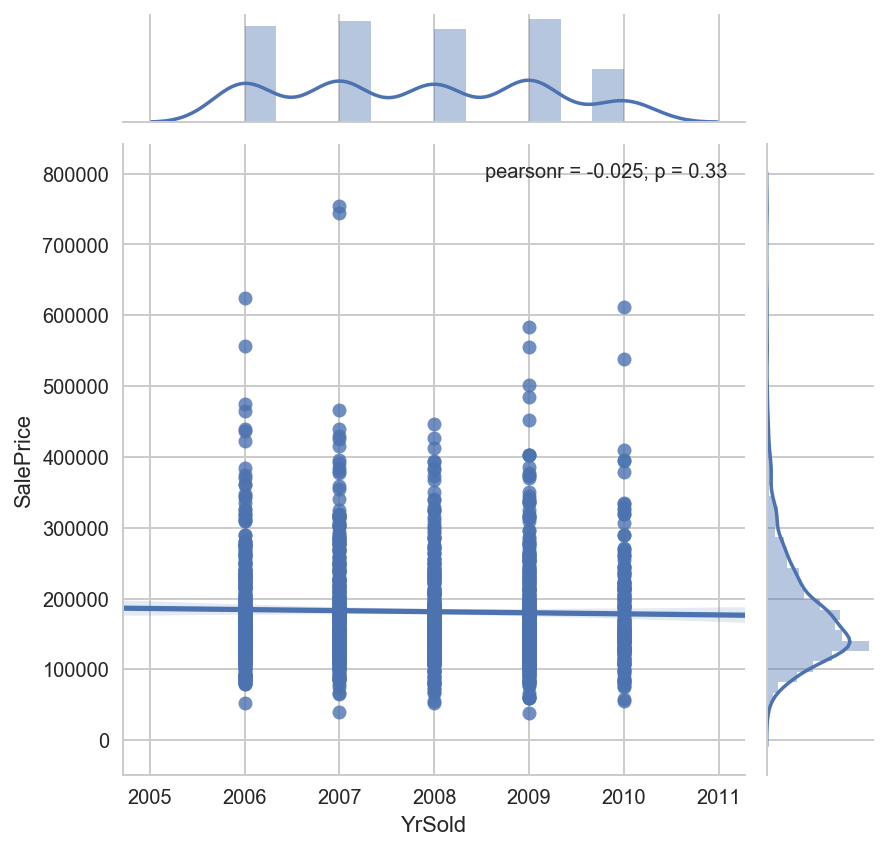

In [19]:
sns.jointplot(x="YrSold", y="SalePrice", data=house, kind="reg")

Sale price of houses and sold year of houses have no corelationship. 

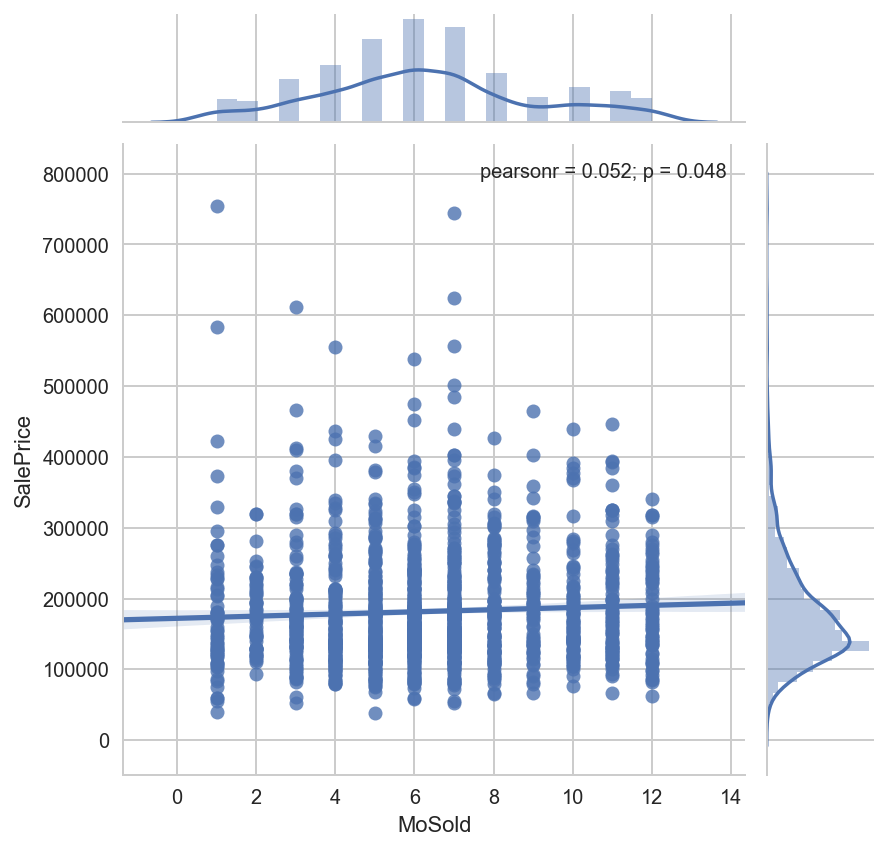

In [20]:
sns.jointplot(x="MoSold", y="SalePrice", data=house, kind="reg")

Similar with year of sold, month of sold also has no strong corelationship with sale price. 

These 2 features should be dropped after feature selection.

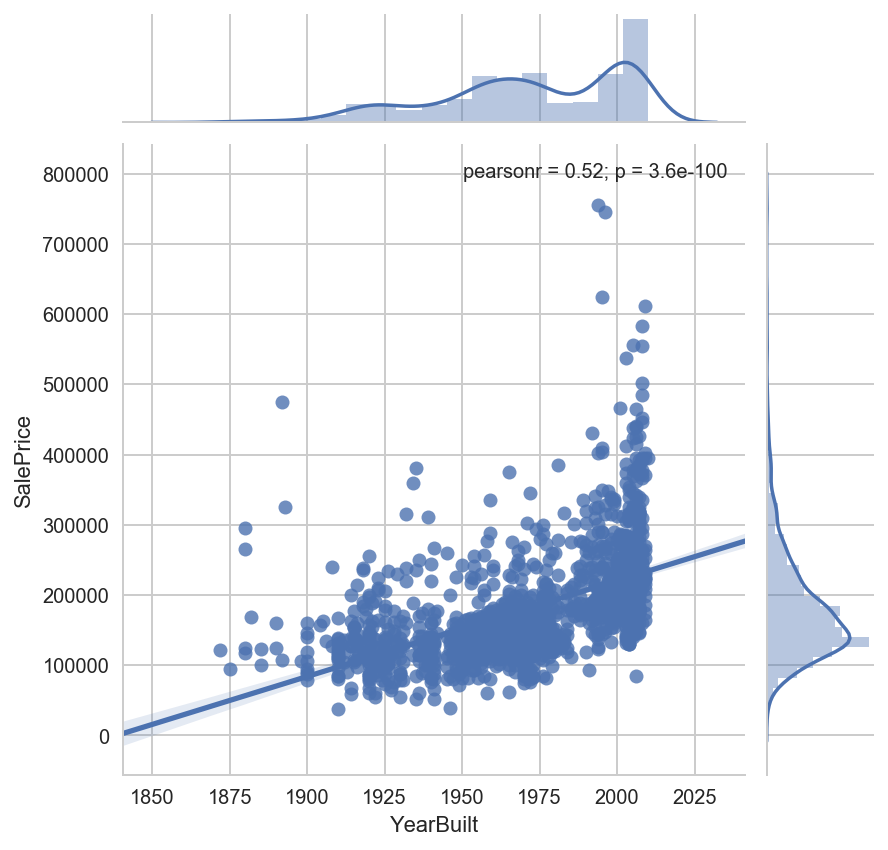

In [21]:
sns.jointplot(x="YearBuilt", y="SalePrice", data=house, kind="reg")

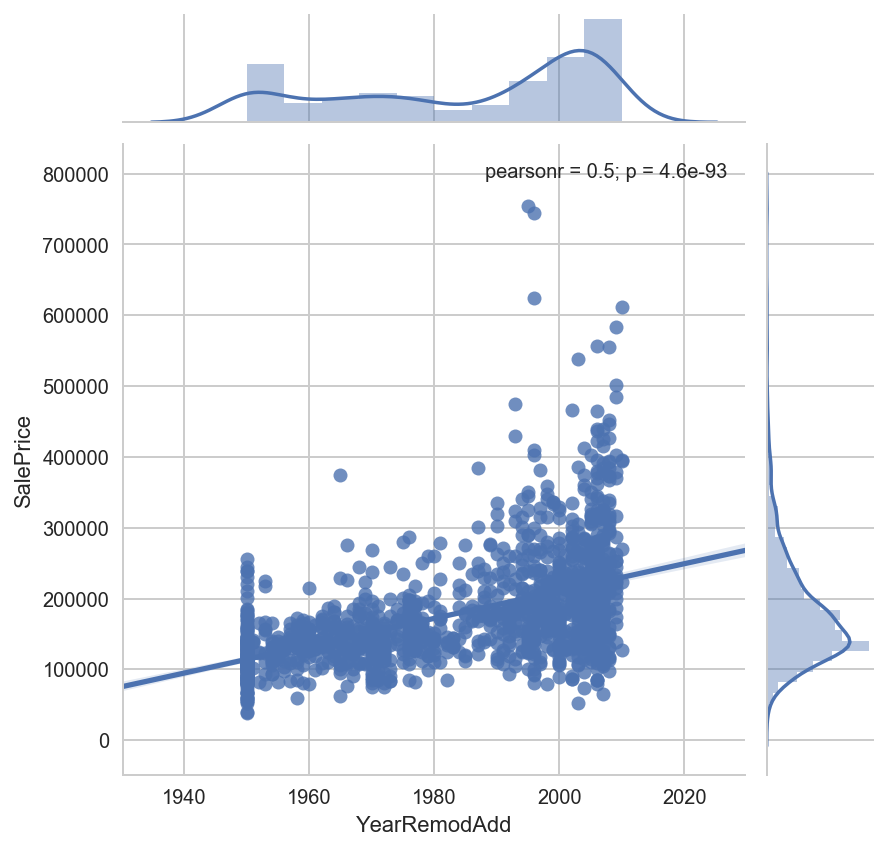

In [22]:
sns.jointplot(x="YearRemodAdd", y="SalePrice", data=house, kind="reg")

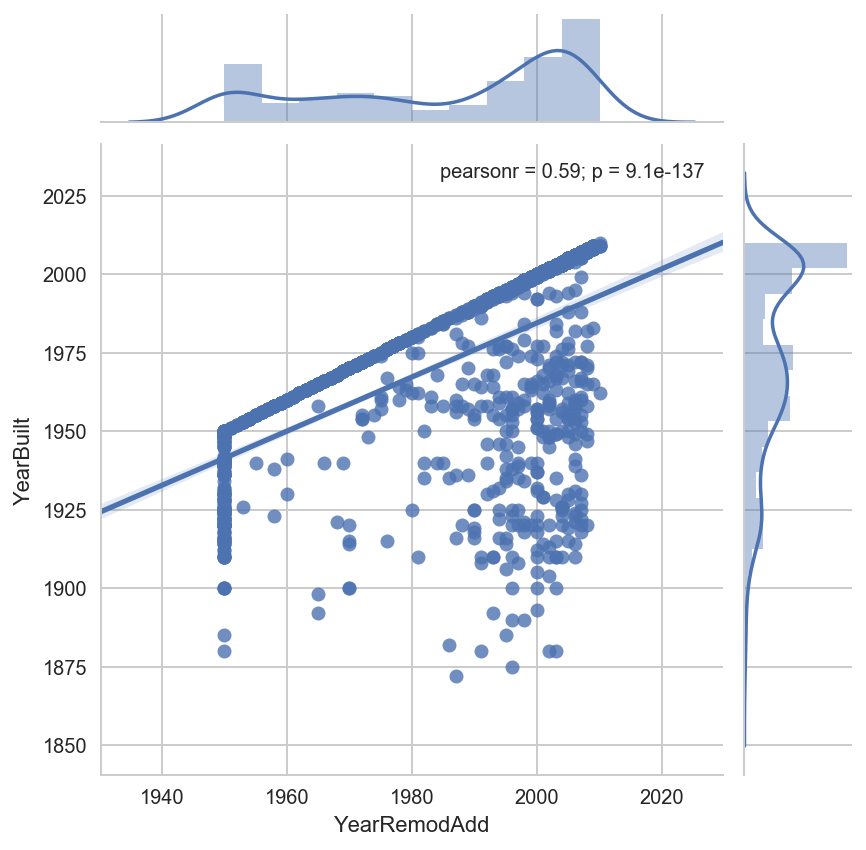

In [23]:
sns.jointplot(x="YearRemodAdd", y="YearBuilt", data=house, kind="reg")

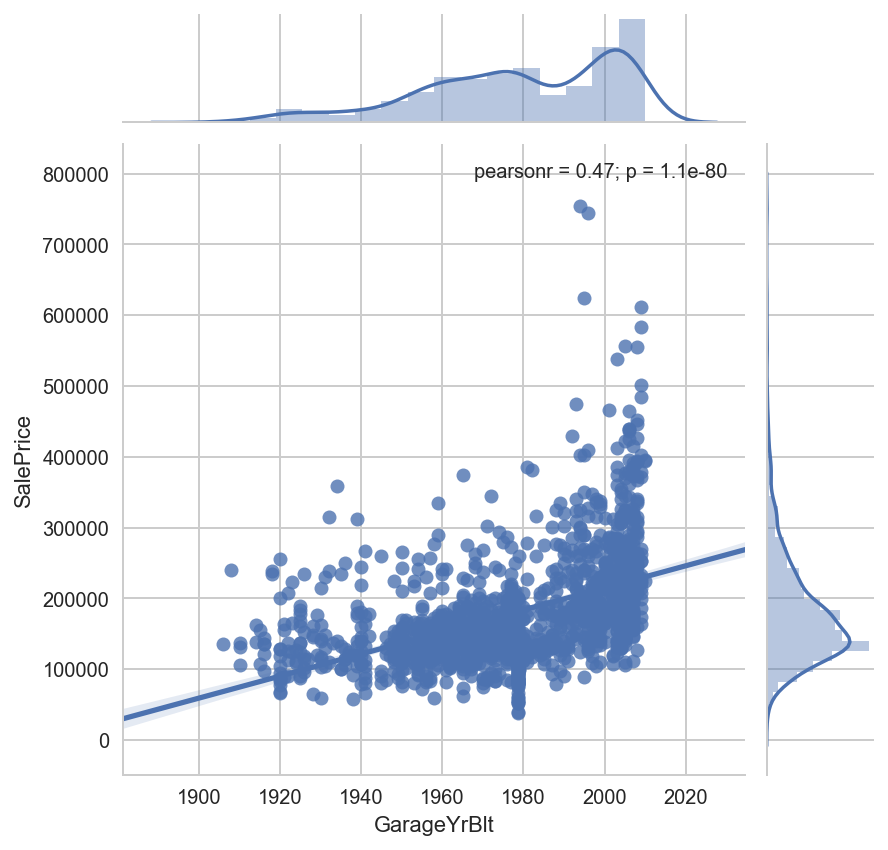

In [24]:
sns.jointplot(x="GarageYrBlt", y="SalePrice", data=house, kind="reg")

Comparing to YrSold and MoSold, YearBuilt, YearRemodAdd and GarageYrBlt are obvious better features associated with sale price.

- YearBuilt: Original construction date
- YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)
- GarageYrBlt: Year garage was built


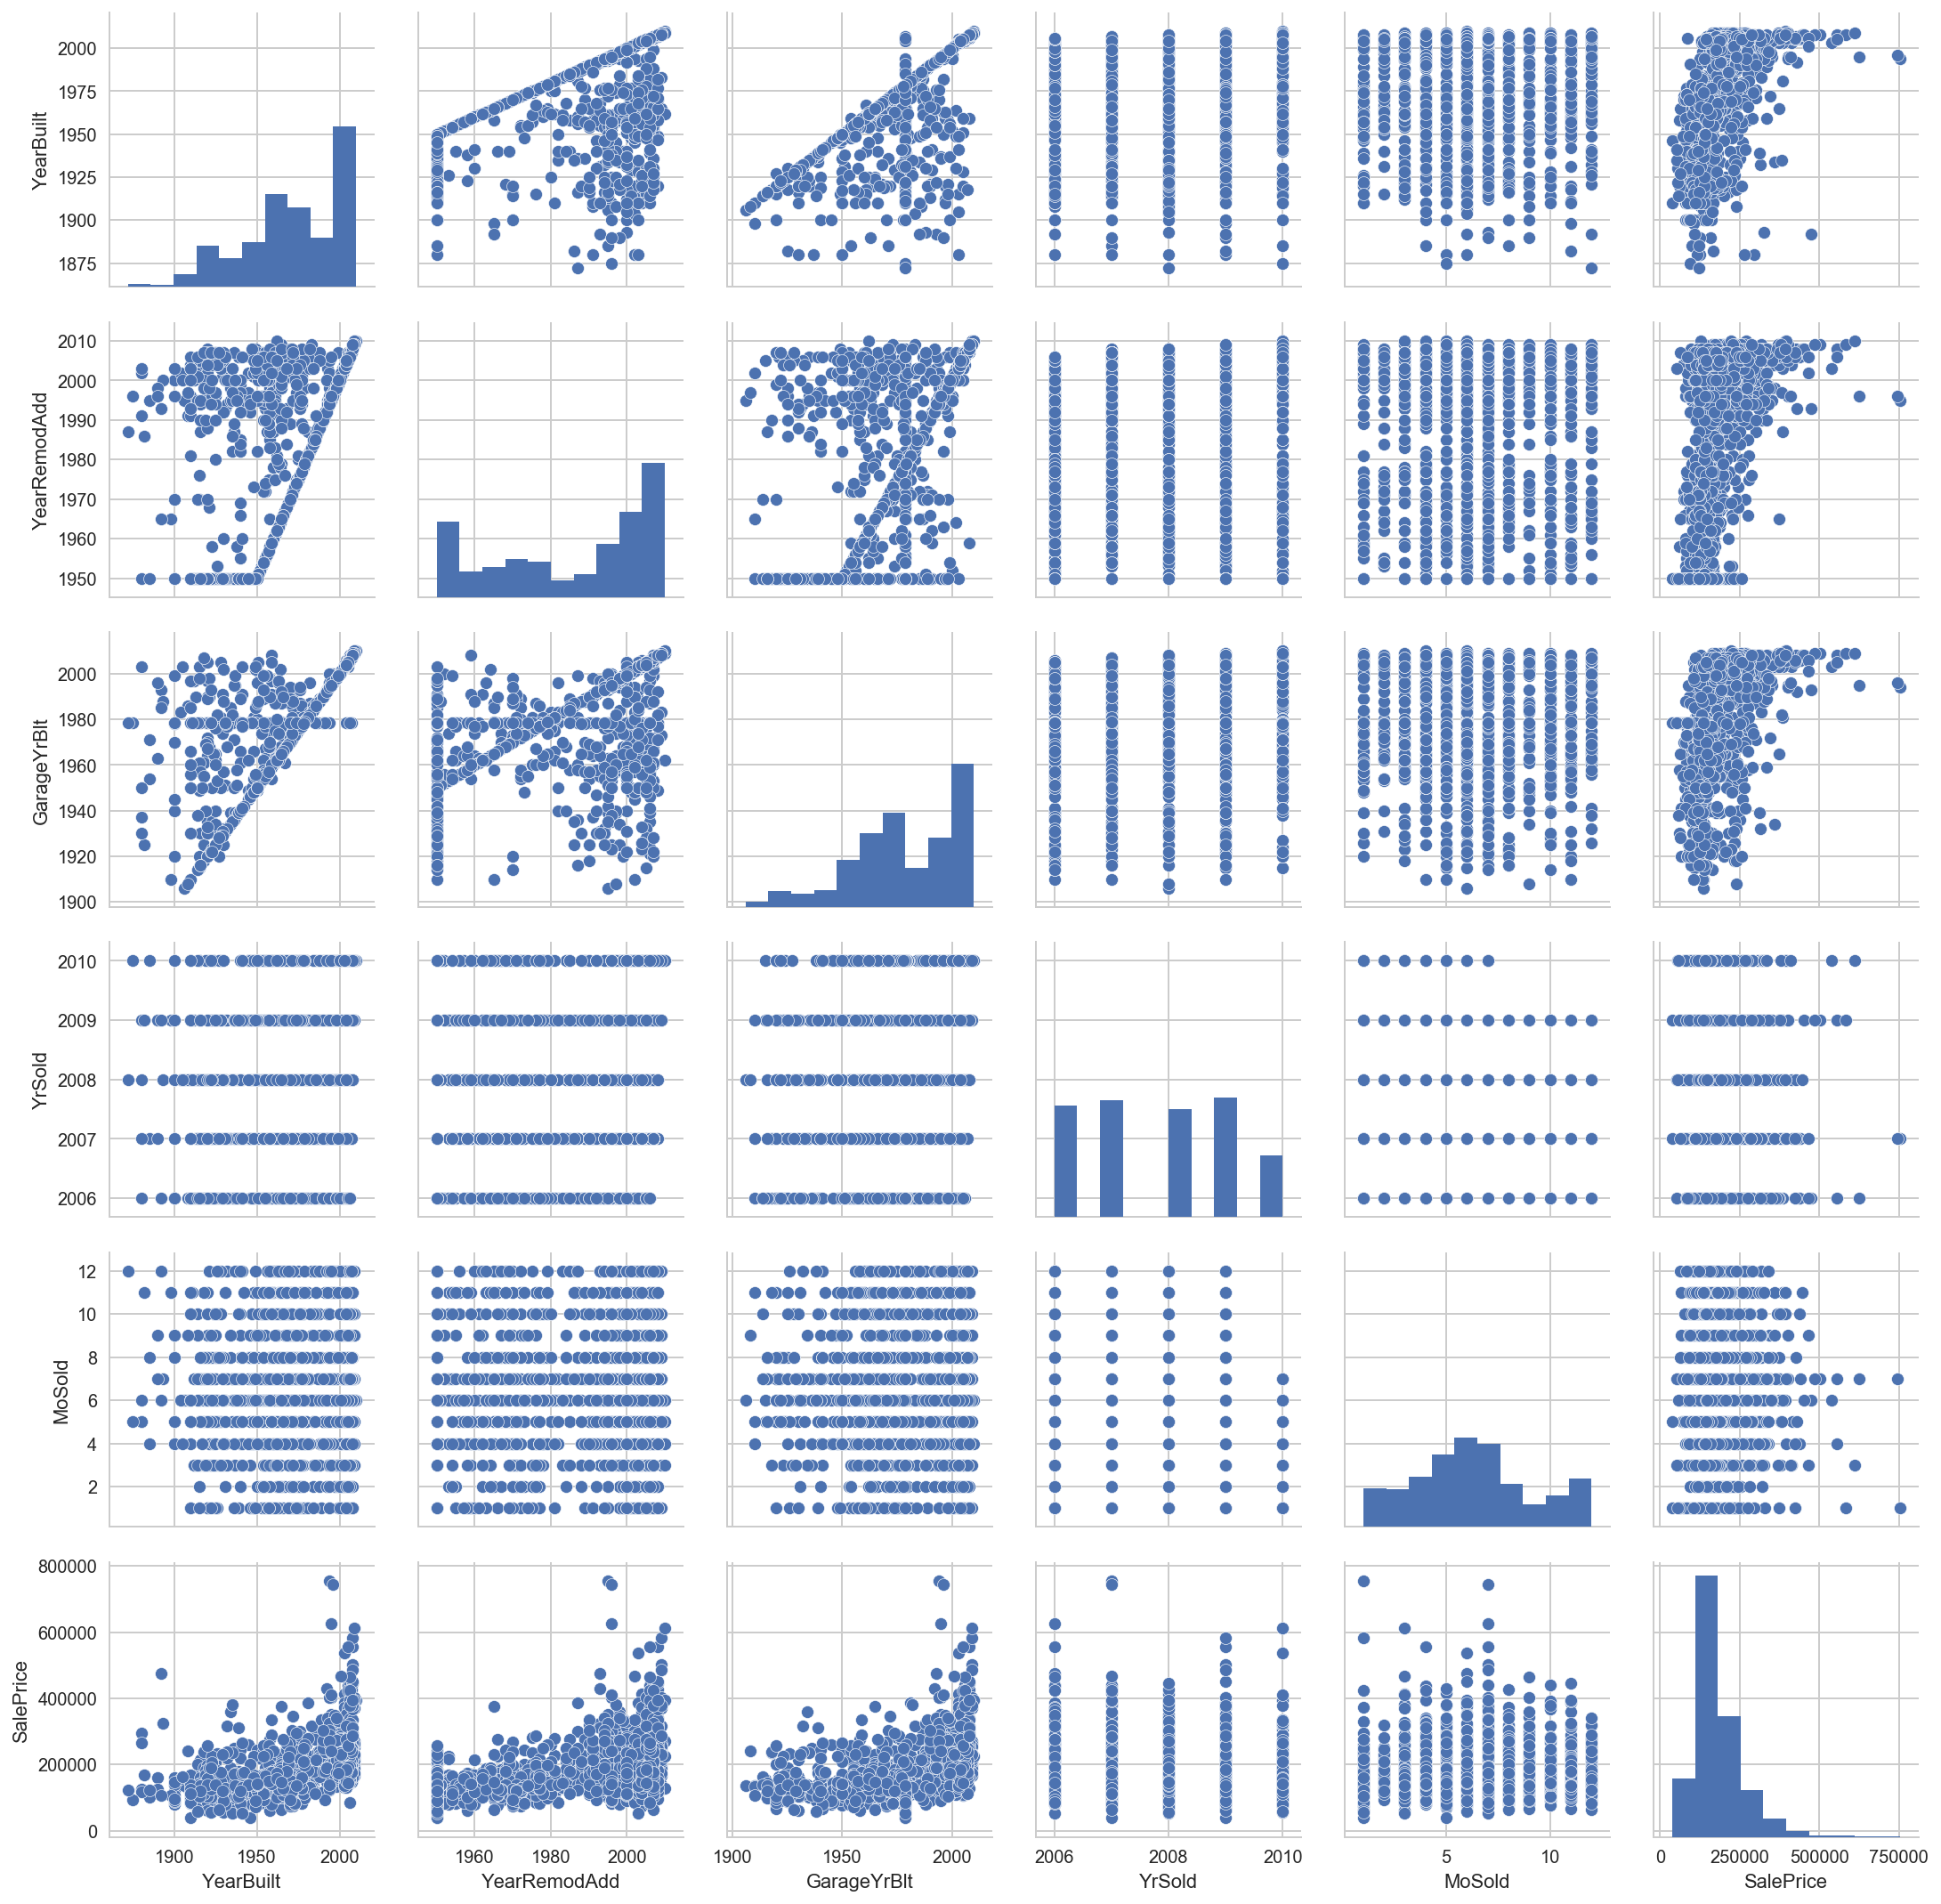

In [25]:
sns.pairplot(house[['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold', 
                   'MoSold', 'SalePrice']])

### Linear relationship between features

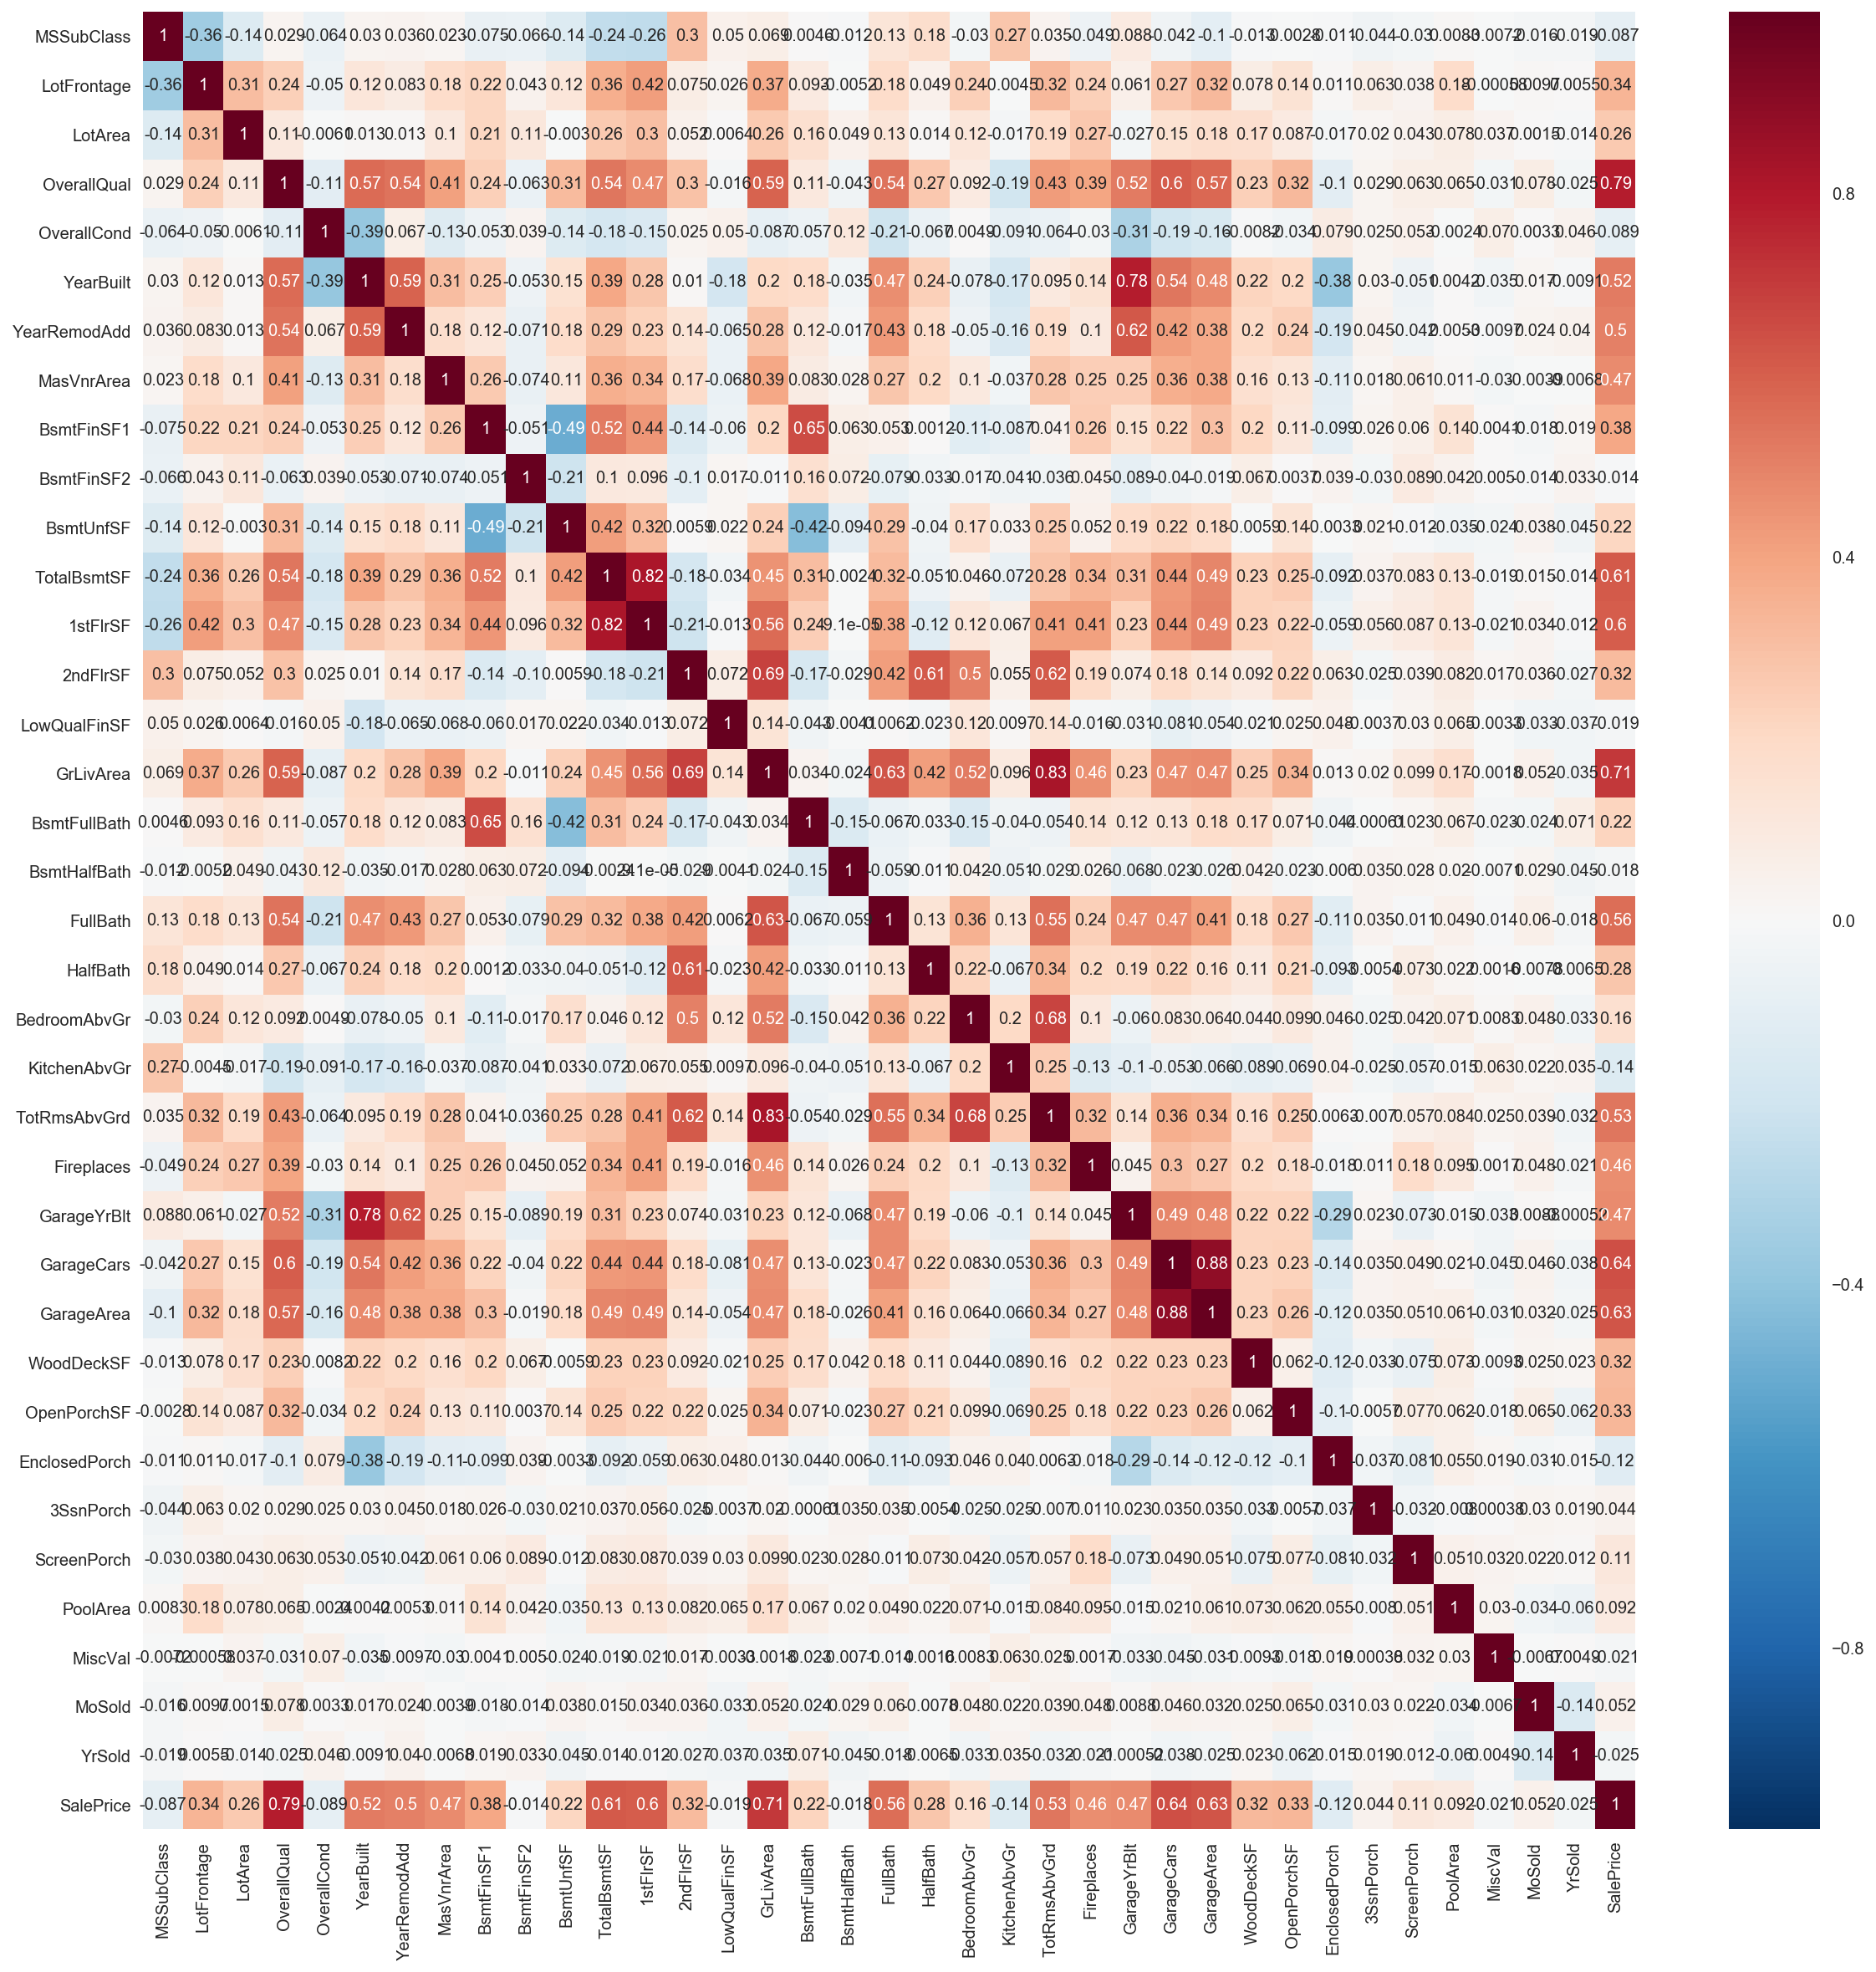

In [26]:
plt.figure(figsize=(20,20))
sns.heatmap(house.corr(), annot=True)

According the plot above, some features have strong corelationship with sale price.

- OverallQual
- TotalBsmtSF
- 1stFlrSF
- GrLiveArea
- GarageCars
- GarageArea

Other finding:

1. GarageYrBlt and YearBuilt have strong corelation (78%)
- GarageArea and GarageCars (88%)
- TotRmsAbvGrd and GrLiveArea (83%)
- 1stFlrSF and TotalBsmtSF (82%)

In general, each of two features in a pair has similar meaning in realistic. For instance, garage built year and house built year have strong corelationship since garage always built with house. 

Those pairs are not good for linear regression since they are strong corelated. Therefore, only one feature from a pair should be chosen for linear regression. 

This is a reference for checking after *feature selection*.

## Identify outliers

In [27]:
# Box plot functions helping mathod to help identify outliers
def boxplot_helper(column):
    fig = plt.figure(figsize=(6,4))
    ax = fig.gca()

    ax = sns.boxplot(column, orient='v',
                fliersize=8, linewidth=1.5, notch=True,
                saturation=0.5, ax=ax)

    ax.set_ylabel(column.name, fontsize=16)
    ax.set_title(column.name, fontsize=20)

    plt.show()
    
def boxplot_all(df, f=(12,6)):
    fig = plt.figure(figsize=f)
    ax = fig.gca()

    ax = sns.boxplot(data=df, orient='h', fliersize=5, linewidth=3, notch=True,
                 saturation=0.5, ax=ax)

    ax.set_title('All variables boxplot\n')
    plt.show()

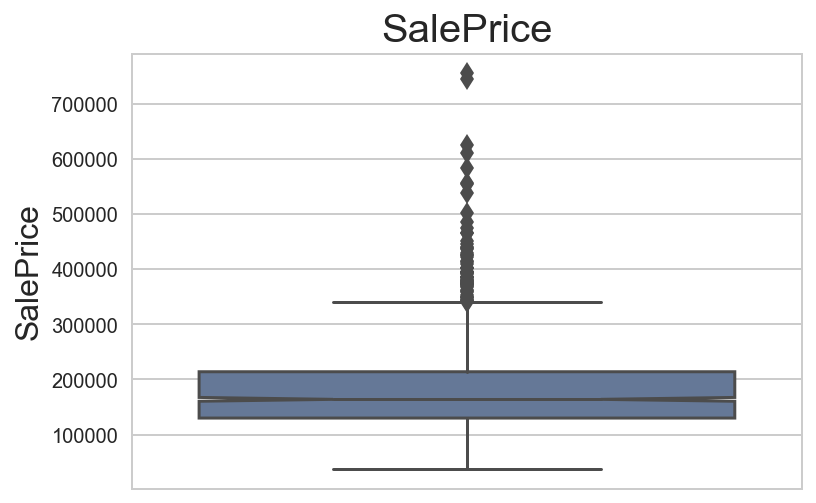

In [28]:
# boxplot of saleprice column
boxplot_helper(fixed_house.SalePrice)

In [29]:
# Split object dtypes columns and numeric dtypes columns
numer_col = []
for c in fixed_house.columns:
    if fixed_house[c].dtypes != 'object':
        numer_col.append(c)

house_numer_cols = fixed_house[numer_col]
house_numer_cols.shape

(1450, 27)

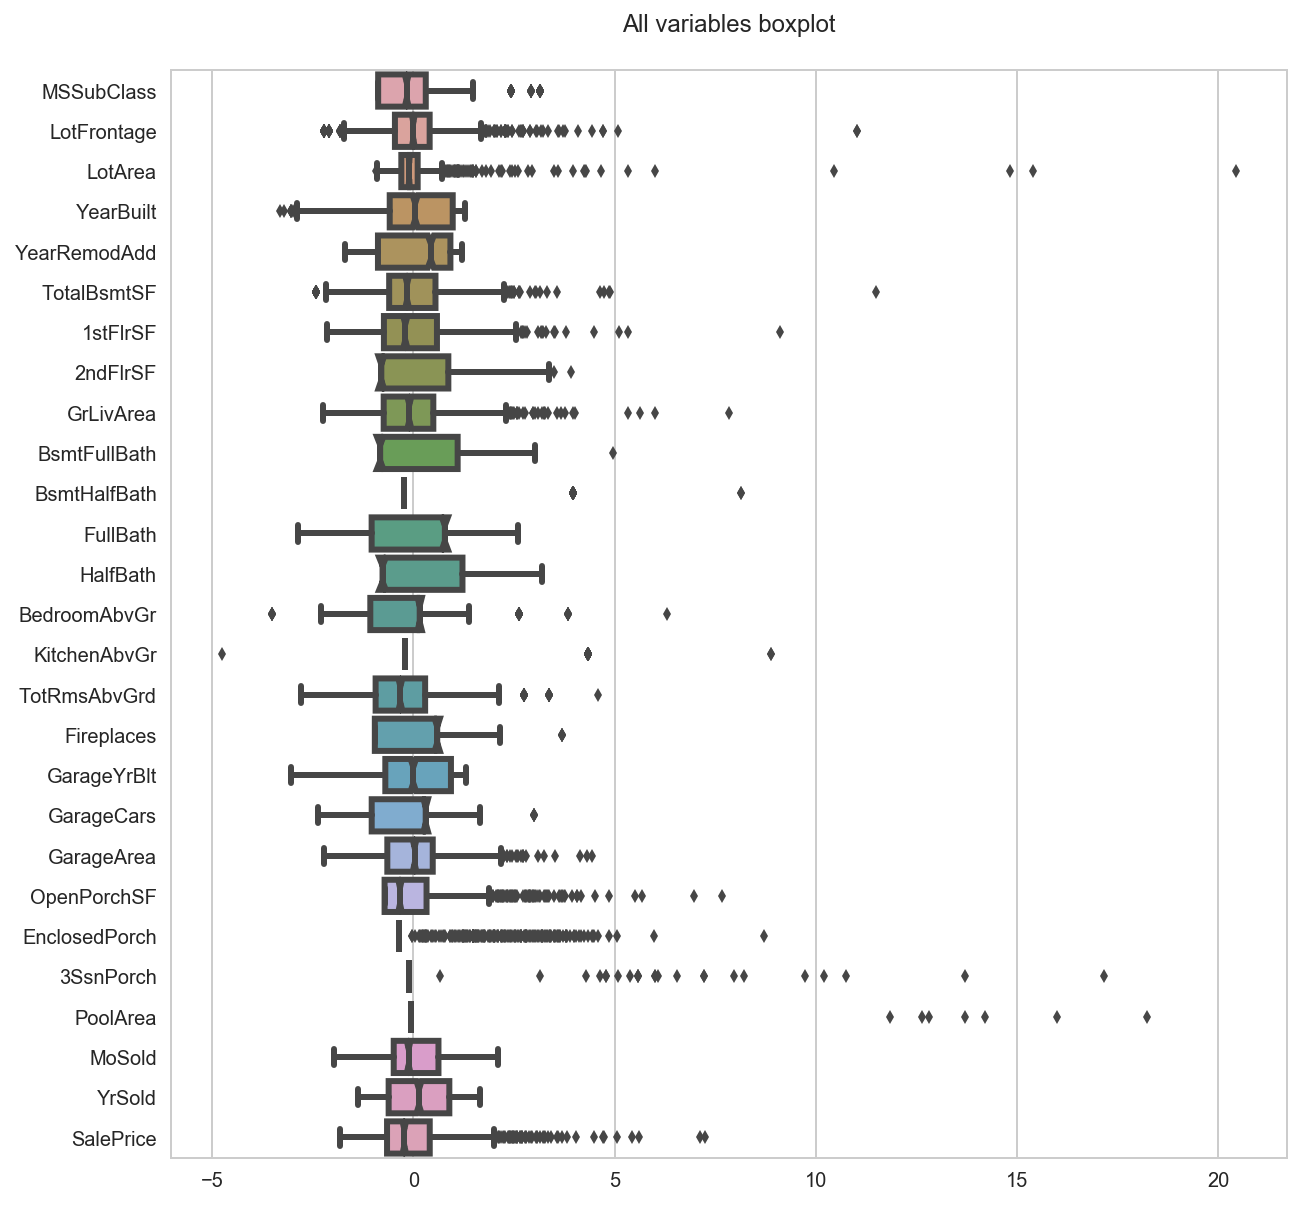

In [30]:
# Standardize numeric data and boxplot it 
hnc_stand = (house_numer_cols - house_numer_cols.mean()) / house_numer_cols.std()
boxplot_all(hnc_stand, f=(10,10))

According to the plot above, we can comfirm that there are a lot of outliers existing. Ths most obvirous outliers sit in "LotArea", "3SsnPorch", "PoolArea". 

- LotArea: Lot size in square feet.
- 3SsnPorch: Three season porch area in square feet.
- PoolArea: Pool area in square feet.

It is hard to come up a realistic reason to decide which is outlier since even outliers seems reasonable. For instance, some house can really have a giant swimming pool comparing most of rest having none. However, outliers sometimes can do real damage to our model since they can make the model skew or bias towards outliers.

Therefore, I'm going to identify outliers and remove it from dataset.

In [31]:
def is_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

Identify ouliers:

(1425, 27)


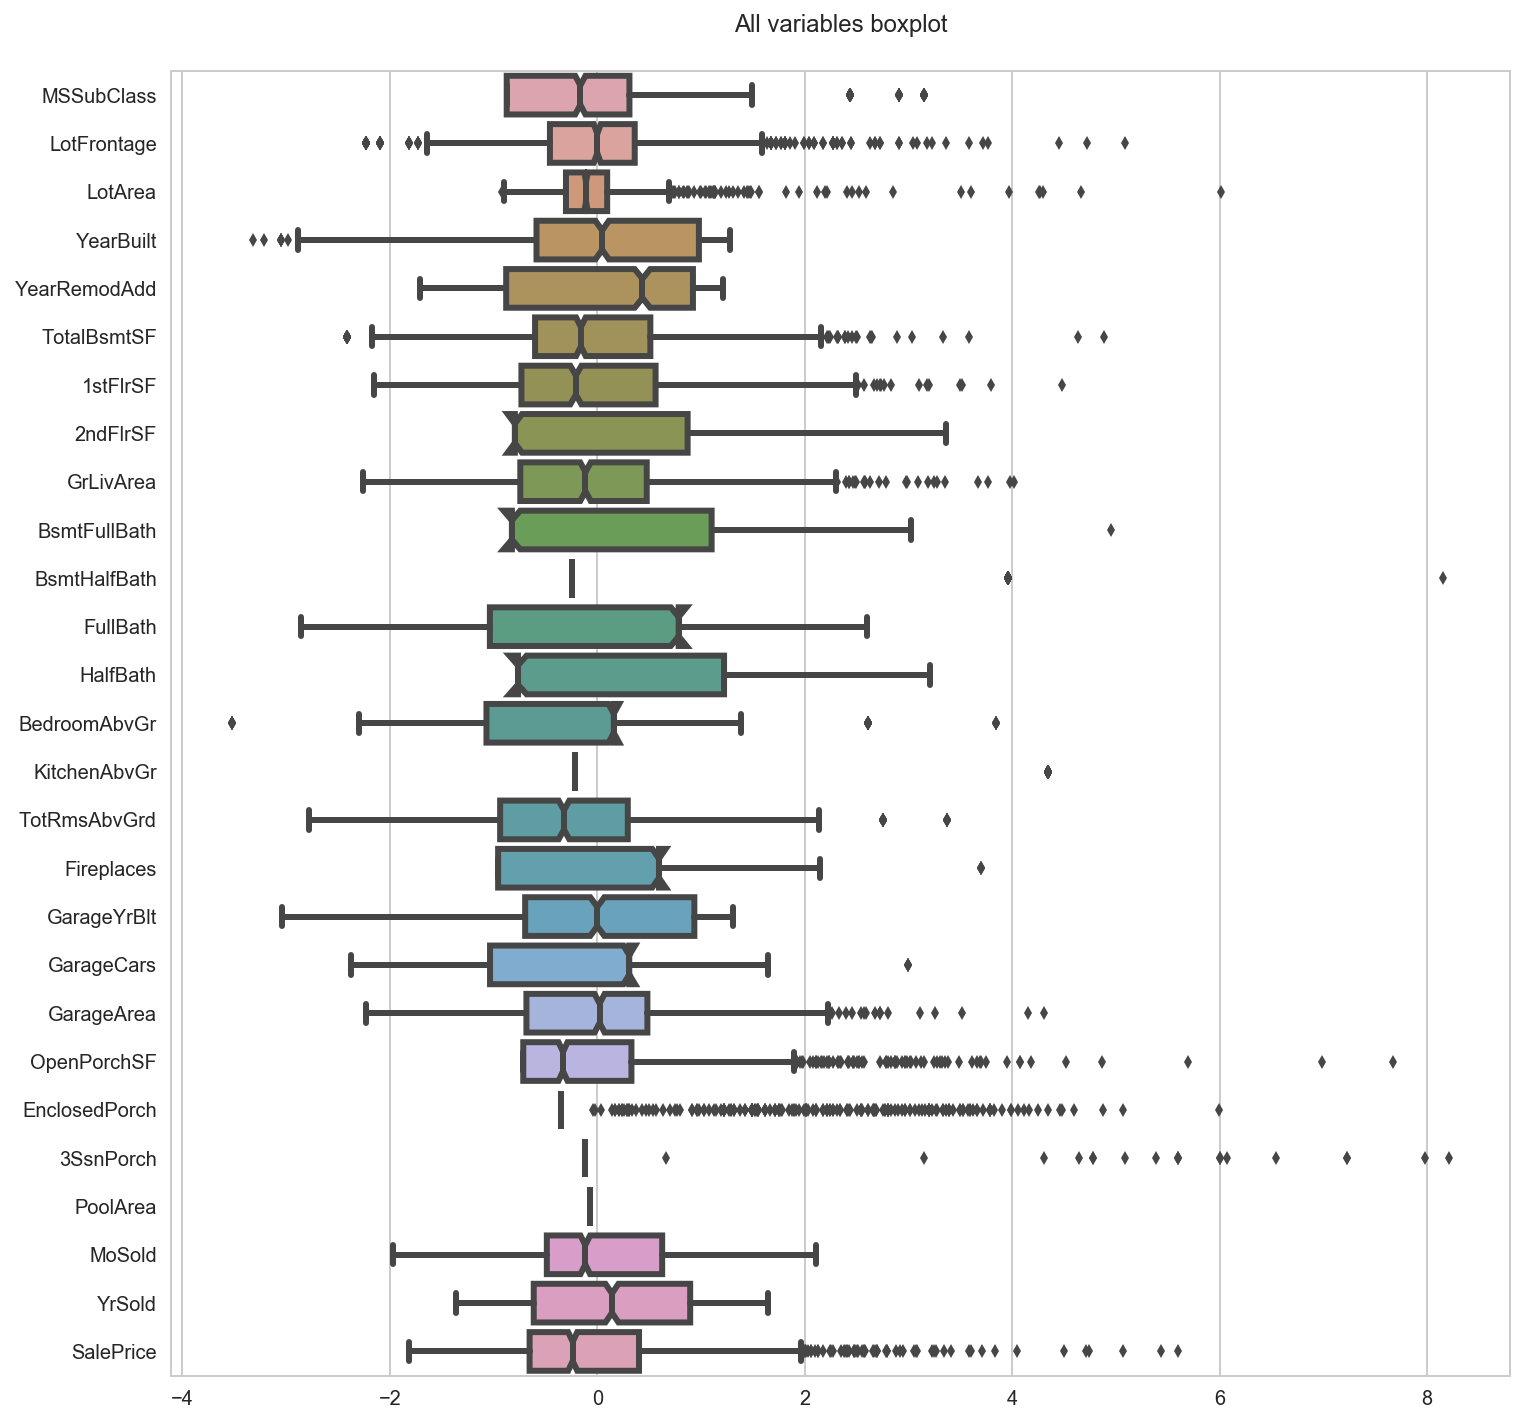

In [32]:
hnc_stand_noout = hnc_stand[~ is_outlier(hnc_stand, thresh=1.5)]
print hnc_stand_noout.shape
boxplot_all(hnc_stand_noout, f=(12,12))

##### Comparing the boxplot before, the range of x-axis (-4 t0 8) is significanly narrowed, which is (-5 to 30) in previous.

There are 25 rows dropped.

In [33]:
house_remove_outlier = fixed_house[~ is_outlier(hnc_stand, thresh=1.5)]
removed_rows = fixed_house[is_outlier(hnc_stand, thresh=1.5)]
print removed_rows.shape, house_remove_outlier.shape

fixed_house = fixed_house[~ is_outlier(hnc_stand, thresh=1.5)]

(25, 34) (1425, 34)


## Feature Selection

### Factorize categorical into dummies variables

In [34]:
# Exact columns with object dtype
object_cols = []
for c in fixed_house.columns:
    if fixed_house[c].dtypes == 'object':
        object_cols.append(c)
print len(object_cols)
house_object = fixed_house.loc[:, object_cols]
print house_object.shape

7
(1425, 7)


In [35]:
# process factorization
for c in object_cols:
    dummies = pd.get_dummies(house_object[[c]], drop_first=True)
    fixed_house = pd.concat([dummies, fixed_house], axis=1)
    fixed_house.drop(c, axis=1, inplace=True)
fixed_house.shape

(1425, 79)

### Spliting data into testing and training group

In [36]:
# spliting data into testing and training group 
# depends on if the house sold in 2010

testing = fixed_house[fixed_house.YrSold == 2010]
training = fixed_house[fixed_house.YrSold != 2010]

testing_y = testing['SalePrice'].values
testing_X = testing.iloc[:, 0:len(fixed_house.columns)-1]

training_y = training['SalePrice'].values
training_X = training.iloc[:, 0:len(fixed_house.columns)-1]

### Feature selection with univariate selection

In [37]:
# feature extraction
select = SelectKBest(score_func=chi2, k=50)
fit = select.fit(training_X, training_y)

# summarize scores
np.set_printoptions(suppress=True)
print(fit.scores_)
X_fs_train = fit.transform(training_X)
X_fs_test = fit.transform(testing_X)

print X_fs_train.shape, X_fs_test.shape

[     432.98277515      573.74972494      518.87580409      578.21694144
      588.9375            5.55614424      416.66666667      625.5
      124.3            1252.              702.8125          490.48687415
       71.8866552       155.60833333      747.87449495      396.49592803
      682.67708333      416.66666667      335.35416667      259.04166667
      701.99444444      540.34565781      397.63295455      642.35997494
      682.21869003      479.40040829      622.23165361      546.09423529
      567.11071429      461.07042104      505.56170977      504.5938057
      449.05457217      919.91344086      958.85894608      545.13836403
      449.42226488      394.77475626      644.33999231      773.53767806
      749.62541667      660.04265233      857.55681818      583.82733135
      521.1377451       642.04022155      585.269375        622.5
      157.74719492      641.82218005      481.58174603       60.62193629
    16837.30330782     3915.37487137  1819937.20999439      391.09

In [38]:
feature_scores = fit.scores_
feature_score = pd.DataFrame(feature_scores).T
feature_score.columns = training_X.columns
feature_score = feature_score.T
feature_score.columns = ['score']
feature_score.sort_values('score', ascending=False).head(10)

score
LotArea        1.819937e+06
2ndFlrSF       3.938412e+05
GrLivArea      1.529668e+05
TotalBsmtSF    1.423961e+05
1stFlrSF       9.666250e+04
3SsnPorch      8.850712e+04
EnclosedPorch  8.812872e+04
GarageArea     8.551787e+04
OpenPorchSF    6.404267e+04
MSSubClass     1.683730e+04

### Feature selection with RFE

In [39]:
selector = RFECV(LinearRegression(), step=1, cv=10)
selector = selector.fit(training_X, training_y)

print selector.support_
print selector.ranking_

rfecv_columns = np.array(training_X.columns)[~ selector.support_]
rfecv_columns

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False  True  True]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 2 1 1]


array(['PoolArea'], dtype=object)

## Build models and evaluation

### Using all features (78)

In [40]:
# Standardize data 
ss = StandardScaler()
ss.fit(training_X, training_y)
Xs_train = ss.transform(training_X)
Xs_test = ss.transform(testing_X)

print training_X.shape

(1253, 78)


In [41]:
# fiting all features into a linear model
lm = LinearRegression()
model = lm.fit(Xs_train, training_y)

# evaluate with training data
print model.score(Xs_train, training_y)
print cross_val_score(lm, Xs_train, training_y, cv=10)

# predict testing data
predict_test = model.predict(Xs_test)

print model.score(Xs_test, testing_y)

0.875297954296
[  8.80487179e-01   8.52626601e-01   8.97598928e-01  -1.38883894e+25
   8.54223502e-01  -2.06533458e+21  -9.58051026e+21   8.25382657e-01
  -4.57222595e+22   8.32665987e-01]
0.858246500922


### Using selected features (50 features)

Univariate feature selection (select k best) does not necessarily get optimal model accuracy when features are interdependent and mutually exclusive.

In [42]:
# Standardize data 
ss2 = StandardScaler()
ss2.fit(X_fs_train, training_y)
Xs_train2 = ss2.transform(X_fs_train)
Xs_test2 = ss2.transform(X_fs_test)

In [43]:
# fiting all features into a linear model
lm2 = LinearRegression()
model2 = lm2.fit(Xs_train2, training_y)

# evaluate with training data
print model2.score(Xs_train2, training_y)
print cross_val_score(lm2, Xs_train2, training_y, cv=10)

# predict testing data
predict_test2 = model2.predict(Xs_test2)

print model2.score(Xs_test2, testing_y)

0.83530875666
[ 0.85883213  0.83594605  0.85746633  0.81149464  0.79969463  0.79460076
  0.77558969  0.77314435  0.74839944  0.83361815]
0.827519176059


### Regularization

In [44]:
l1_ratios = np.linspace(0.001, 1.0, 100)

optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, cv=10, verbose=1)
optimal_enet.fit(Xs_train, training_y)

print optimal_enet.alpha_
print optimal_enet.l1_ratio_

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

360.693625143
1.0


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   30.0s finished


In [45]:
enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)

enet_scores = cross_val_score(enet, Xs_train, training_y, cv=10)

print enet_scores
print np.mean(enet_scores)

enet.fit(Xs_train, training_y)
print enet.score(Xs_train, training_y), enet.score(Xs_test, testing_y)

[ 0.88624513  0.87588539  0.89502114  0.87332169  0.84690891  0.84959504
  0.85932551  0.82292264  0.79626979  0.83720248]
0.854269772409
0.873147796155 0.860644746921


### Ridge regression

In [52]:
ridge_alphas = np.logspace(0, 5, 200)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(Xs_train, training_y)

print optimal_ridge.alpha_

68.2607183427


In [53]:
ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge_scores = cross_val_score(ridge, Xs_train, training_y, cv=10)

print ridge_scores
print np.mean(ridge_scores)

ridge.fit(Xs_train, training_y)
print ridge.score(Xs_train, training_y), ridge.score(Xs_test, testing_y)

[ 0.8837301   0.8753866   0.89426382  0.86902714  0.85126435  0.84976353
  0.85628579  0.82135819  0.79712204  0.83842423]
0.853662578799
0.87395954179 0.858941346792


### Lasso reg

In [56]:
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(Xs_train, training_y)

print optimal_lasso.alpha_

lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, Xs_train, training_y, cv=10)

print lasso_scores
print np.mean(lasso_scores)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

370.353085464
[ 0.8862791   0.87618299  0.89491977  0.87341634  0.84675952  0.84968022
  0.85948923  0.82283115  0.79618111  0.83727498]
0.854301441907


# Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.


What are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value.
- The effects must be on the variance in price remaining from the first model.

Your goals:
1. Evaluate the effect in dollars of the renovate-able features.
- How would your company use second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money.
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

## Get residuals (y)

In [57]:
fix = fixed_house.copy()
fix_X = fix.iloc[:, :-1]
Xs = ss.transform(fix_X)
fix['predict_price'] = enet.predict(Xs)

In [58]:
fix['residual'] = fix.predict_price - fix.SalePrice
fix = fix.applymap(round)
fix.predict_price = fix.predict_price.astype(int)
fix.residual = fix.residual.astype(int)

In [59]:
y = fix.residual.values

## Set predictors (X)

In [60]:
all_feature = house.columns
unfixed_feature = [x for x in all_feature if x not in fixed_feature]
unfixed_house = house[unfixed_feature].iloc[:,:-2]

In [67]:
unfixed_house = unfixed_house[house.MSZoning != 'C (all)']
for col in unfixed_house.columns:
    if unfixed_house[col].dtype == 'object':
        unfixed_house[col] = unfixed_house[col].factorize()[0]

X = unfixed_house
X.shape

(1450, 45)

In [68]:
X.MasVnrArea = X.MasVnrArea.fillna(X.MasVnrArea.mean())
X.isnull().sum().sum()

/Users/alex/anaconda2/lib/python2.7/site-packages/pandas/core/generic.py:2999: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


0L

In [70]:
X = X[~ is_outlier(hnc_stand, thresh=1.5)]

## Fit model and evaluate

In [71]:
Xs = ss.fit_transform(X)

lr2 = LinearRegression()
model3 = lr2.fit(Xs, y)
print model3.score(Xs, y)
cross_val_score(lr2, Xs, y, cv=10)

0.261273954032


array([  2.63262416e-02,   8.99442766e-02,   1.95669103e-01,
         2.02903612e-01,   2.17073342e-01,   7.77181095e-02,
        -3.77138226e+21,   1.62782435e-01,   3.20578376e-01,
         1.74170754e-01])

In [ ]:
# y 
y_hat = model3.predict(Xs)

def accuracy(y, y_hat, precent=0.1):
    a = 0
    pair = zip(y, y_hat)
    for p in pair:
        i, j = p
        if i < 0 and j > 0:
            a += 1
    return 1 - float(a) / len(pair)

print accuracy(y, y_hat, precent=0.5)

sns.jointplot(y, y_hat)

residuals = predict price - actural price

So, if residual > 0, then we can make profit.

In this model:
- If predict residual > 0 and actural residual > 0, then we suggest that company should buy this proporty.
- If predict residual < 0 and actural residual < 0, then we suggest that company should not buy this proporty.
- If predict residual < 0 and actural residual > 0, we will suggest not buying. Company won't lose money.

In [ ]:
l1_ratios = np.linspace(0.001, 1.0, 100)

optimal_enet2 = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, cv=10, verbose=1)
optimal_enet2.fit(Xs, y)

enet2 = ElasticNet(alpha=optimal_enet2.alpha_, l1_ratio=optimal_enet2.l1_ratio_)

enet_scores2 = cross_val_score(enet2, Xs, y, cv=10)

print enet_scores2
print np.mean(enet_scores2)


In [ ]:
enet2.fit(Xs, y)
y_hat2 = enet2.predict(Xs)

sns.jointplot(y, y_hat2)

print accuracy(y, y_hat2, precent=2)

# What property characteristics predict an "abnormal" sale?


## Load data

In [ ]:
df = pd.read_csv('./housing.csv')
df.drop(['SalePrice', 'YrSold', 'MoSold', 'Id'], axis=1, inplace=True)

## Set y

In [ ]:
df.SaleCondition = (df.SaleCondition == 'Abnorml')
df.SaleCondition = df.SaleCondition.astype(int)

y = df.SaleCondition.values

## Set X

In [ ]:
X = df.iloc[:, :-1]

In [ ]:
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = X[col].factorize()[0]

In [ ]:
for c in X.columns:
    if X[c].isnull().sum() > 0:
        X[c] = X[c].fillna(X[c].mean())
X.isnull().sum().sum()

## Feature selection

In [ ]:
lr = LogisticRegression()

selector = RFECV(lr, step=1, cv=10)
selector = selector.fit(X, y)

print selector.support_
print selector.ranking_

rfecv_columns = np.array(X.columns)[selector.support_]
rfecv_columns

In [ ]:
X = X[rfecv_columns]
X.shape

## Fit model and evaluate

### KNN

In [ ]:
knn5 = KNeighborsClassifier(n_neighbors=5)
knn5.fit(X, y)

cv_score = cross_val_score(knn5, X, y, cv=10)
print cross_val_score(knn5, X, y, cv=10)
print knn5.score(X, y), cv_score.mean()

### Logistic regression

In [ ]:
ss = StandardScaler()
Xs = ss.fit_transform(X)

lr = LogisticRegression()
lr.fit(Xs, y)

cv_scores = cross_val_score(lr, Xs, y, cv=10)
print lr.score(Xs, y), cv_scores.mean()